In [1]:
%matplotlib inline
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable

In [2]:
from midox import midiread, midiwrite
import pretty_midi
import subprocess
import taglib
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink, Audio

from utils import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
output_file_name = 'output_classic_ed.mid'

base_dataset_path = '../adl-piano-midi/Classical/Classical/Johann Sebastian Bach'

major_notes = False

train = True

# DataLoader

In [5]:
trainset = NotesGenerationDataset(base_dataset_path, adl_dataset=True, type='train')

trainset_loader = Data.DataLoader(trainset, batch_size=1, shuffle=True, drop_last=True)

In [6]:
X = next(iter(trainset_loader))
print(X[0].shape)

keys_shape = X[0].shape[2]

torch.Size([1, 78700, 128])


In [7]:
if train:
    valset = NotesGenerationDataset(base_dataset_path, adl_dataset=True, type='val')

    valset_loader = Data.DataLoader(valset, batch_size=1, shuffle=False, drop_last=False)

In [8]:
if train:
    X_val = next(iter(valset_loader))
    X_val[0].shape

# RNN

In [9]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers = 2, is_bidirect = False):
        super(lstm_encoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.is_bidirect = is_bidirect

        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        # self.bn = nn.BatchNorm1d(hidden_size)

        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=is_bidirect)
        
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        notes_encoded = self.notes_encoder(input_sequences)
        
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        # notes_encoded_norm = self.bn(notes_encoded_rolled)
        
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_rolled)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs, hidden = self.gru(packed, hidden)
        return hidden

In [10]:
class lstm_decoder(nn.Module):
    def __init__(self, hidden_size, num_classes, n_layers = 2, is_bidirect = False):
        super(lstm_decoder, self).__init__()

        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        self.is_bidirect = is_bidirect

        self.notes_decoder = nn.Linear(in_features=hidden_size, out_features=num_classes)
        
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=is_bidirect)
        
    def forward(self, hidden_vector, batch_size=1):
        decoder_input = torch.empty(batch_size, 1, self.hidden_size, dtype=torch.float, device=device).fill_(0)
        decoder_hidden = hidden_vector
        decoder_outputs = []

        for i in range(1):
            # print(decoder_input.shape, decoder_hidden[0].shape, decoder_hidden[1].shape)
            decoder_output, decoder_hidden = self.gru(decoder_input, decoder_hidden)
            decoder_output = nn.Dropout(0.25)(decoder_output)
            decoder_output = self.notes_decoder(decoder_output)
            decoder_outputs.append(decoder_output)
            decoder_input = decoder_input[:, i].unsqueeze(1)

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs, decoder_hidden

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2, is_bidirect=False):
        super(RNN, self).__init__()
        
        self.encoder = lstm_encoder(input_size, hidden_size, n_layers, is_bidirect)
        self.decoder = lstm_decoder(hidden_size, num_classes, n_layers, is_bidirect)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[0]
        encoder_hidden = self.encoder(input_sequences, input_sequences_lengths, hidden)
        logits, decoder_hidden = self.decoder(encoder_hidden, batch_size)
        logits = logits.transpose(0, 1).contiguous()
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking,crossentropy is used
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, decoder_hidden

In [12]:
model = RNN(input_size=keys_shape, hidden_size=512, num_classes=keys_shape).to(device)

criterion = nn.CrossEntropyLoss().to(device)
criterion_val = nn.CrossEntropyLoss().to(device)

In [13]:
if train:
    validate(model, valset_loader, criterion_val)

100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


In [14]:
clip = 1.0
epochs_number = 10
sample_history = []
best_val_loss = float("inf")

In [15]:
def lrfinder(start, end, model, trainset_loader, epochs=2):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(trainset_loader))
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(model.parameters(),start)
    loss_list = []
    ctr = 0
    
    for epoch_number in range(epochs):
        epoch_loss = []
        print('Epoch %d' % epoch_number)
        for batch in tqdm(trainset_loader):
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr+1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).to(device) )
            input_sequences_batch_var = Variable( input_sequences_batch.to(device) )

            # fake = input_sequences_batch_var[:, 0:1, :]

            # plt.figure(figsize=(10,6))
            # plt.imshow(fake.cpu().numpy().reshape((fake.shape[0],88)).transpose(0,1))

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            epoch_loss.append(loss.item())
        
        print('Loss %.4f' % np.mean(epoch_loss))
        plt.plot(range(len(trainset_loader)), epoch_loss)
        plt.show()
    plt.plot(lrs, loss_list)
    return lrs, loss_list

Epoch 0


100%|██████████| 112/112 [04:52<00:00,  2.61s/it]

Loss 0.5200


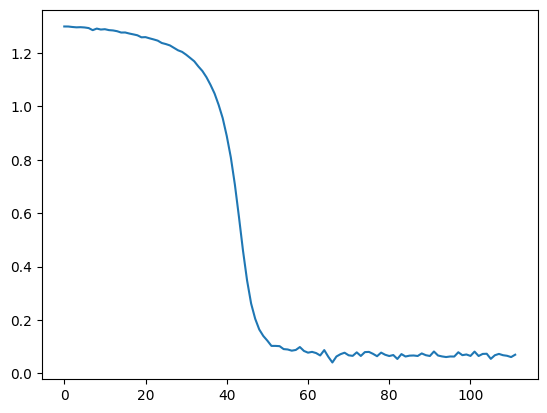

Epoch 1


100%|██████████| 112/112 [08:49<00:00,  4.73s/it]

Loss 0.0671


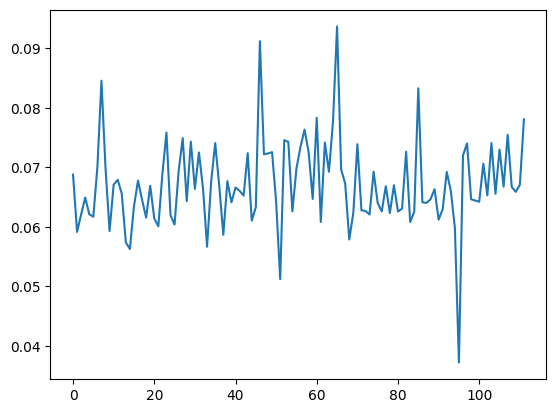

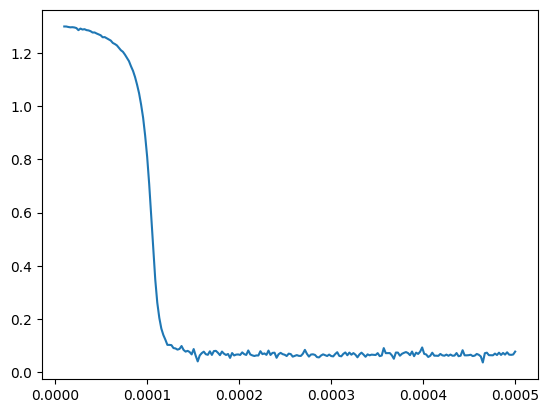

In [16]:
if train:
    rnn = RNN(input_size=keys_shape, hidden_size=512, num_classes=keys_shape).to(device)
    lrs, losses = lrfinder(1e-5, 5e-4, rnn, trainset_loader)

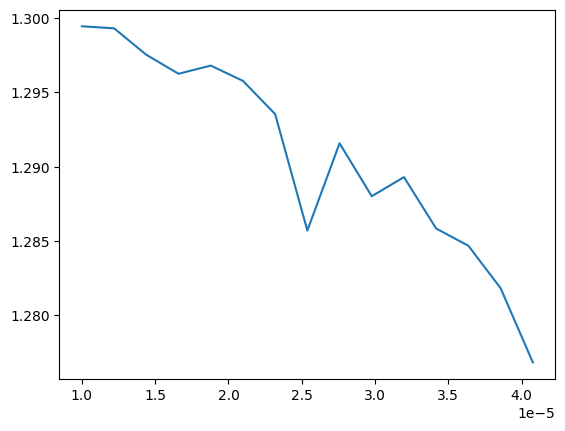

In [17]:
if train:
    plt.plot(lrs[:15], losses[:15])

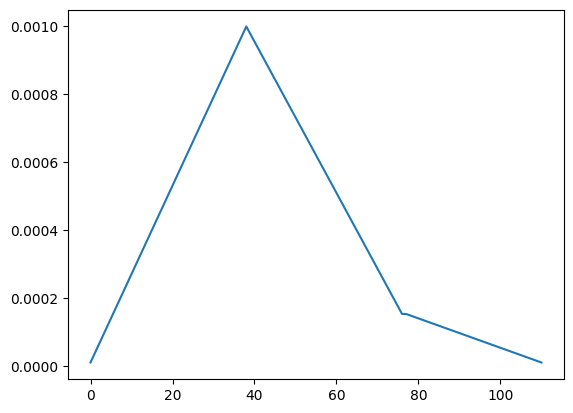

In [18]:
if train:
    def get_triangular_lr(lr_low, lr_high, mini_batches):
        iterations = mini_batches
        lr_mid = lr_high/7 + lr_low
        up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
        down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
        floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.30)))
        return np.hstack([up, down[1:], floor])

    lrs_triangular = get_triangular_lr(1e-5, 1e-3, len(trainset_loader))
    plt.plot(lrs_triangular)

In [19]:
if train:
    rnn = RNN(input_size=keys_shape, hidden_size=512, num_classes=keys_shape).to(device)
    lrs_triangular = get_triangular_lr(1e-5, 1e-4, len(trainset_loader))
    best_val_loss = train_model(rnn, lrs_triangular, trainset_loader, criterion, valset_loader, criterion_val, save_path='music_model_padfront_regularized_ed.pth')

Epoch:  0


111it [09:55,  5.36s/it]


Training Loss: Epoch: 0 : 0.5035941077263227


100%|██████████| 24/24 [00:52<00:00,  2.17s/it]


Validation Loss: Epoch: 0 : 5.8626529918529944e-08

Epoch:  1


111it [09:55,  5.36s/it]


Training Loss: Epoch: 1 : 0.06979408045299351


100%|██████████| 24/24 [00:52<00:00,  2.19s/it]

Validation Loss: Epoch: 1 : 5.303317259111286e-08



In [20]:
if train:
    lrs_triangular = get_triangular_lr(1e-6, 1e-4, len(trainset_loader))
    best_val_loss = train_model(rnn, lrs_triangular, trainset_loader, criterion, valset_loader, criterion_val, epochs_number=2, wd=1e-4, best_val_loss=best_val_loss, save_path='music_model_padfront_regularized_ed.pth')

Epoch:  0


18it [01:28,  6.45s/it]

In [ ]:
if train:
    lrs_triangular = get_triangular_lr(1e-5, 1e-4, len(trainset_loader))
    best_val_loss = train_model(rnn, lrs_triangular, trainset_loader, criterion, valset_loader, criterion_val, epochs_number=2, wd=1e-4*5, best_val_loss=best_val_loss, save_path='music_model_padfront_regularized_ed.pth')

In [ ]:
rnn = RNN(input_size=keys_shape, hidden_size=512, num_classes=keys_shape).to(device)
rnn.load_state_dict(torch.load('music_model_padfront_regularized_ed.pth'))

<All keys matched successfully>

# Validation

In [ ]:
def sample_from_piano_rnn(model, sample_length=4, temperature=1, starting_sequence=None):
    if starting_sequence is None:
        current_sequence_input = torch.zeros(1, 1, keys_shape)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.to(device))
    else:
        current_sequence_input = starting_sequence
        
    final_output_sequence = [current_sequence_input.data.squeeze(1)]

    hidden = None

    model.eval()

    prev = 0

    i = 0

    while i < (sample_length + 10):
        output, hidden = model(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.divide(temperature), dim=1)
        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)
        current_sequence_input = Variable(current_sequence_input.float())

        if not current_sequence_input.data.squeeze(1).cpu().numpy()[0].any():
            prev +=1
        else:
            prev = 0
        
        if prev >= 4:
            continue

        i+=1
        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence[10:], dim=0).cpu().numpy()
    
    return sampled_sequence

In [ ]:
testset =  NotesGenerationDataset(base_dataset_path, adl_dataset=True, type='test')

testset_loader = Data.DataLoader(testset, batch_size=1,shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(testset_loader))
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)

input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).to(device)

input_sequences_batch_var = input_sequences_batch.to(device)
input_sequences_batch_var.shape

torch.Size([3899, 1, 128])

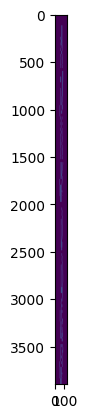

In [ ]:
plt.imshow(input_sequences_batch_var.cpu().numpy().reshape((input_sequences_batch_var.shape[0],keys_shape)).transpose(0,1))

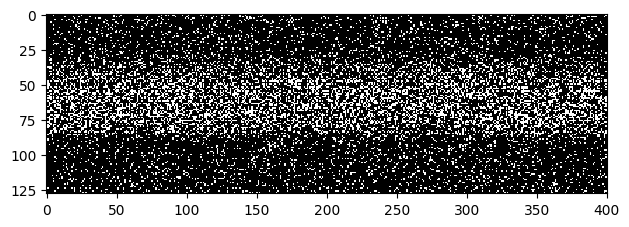

In [ ]:
piano_roll = sample_from_piano_rnn(rnn, sample_length=400, temperature=0.95, starting_sequence=None)
io.imshow(piano_roll.transpose())
plt.show()

In [ ]:
midiwrite(output_file_name, piano_roll, dt=0.15, r=(0, 109))

# from pypianoroll import Multitrack, BinaryTrack
# piano_roll[:, 89:] = 0
# track_name = 'Piano'
# pianoroll_track = BinaryTrack(pianoroll=piano_roll, name=track_name)
# multitrack_name = 'MyMultitrack'  # Set a name for the multitrack
# multitrack = Multitrack(tracks=[pianoroll_track], name=multitrack_name, resolution=1)
# print(multitrack)
# multitrack.write('output.mid')

In [ ]:
piano_roll.shape

(401, 128)

In [ ]:
def is_major_note(note):
    # Check if the note is a major note (C, D, E, F, G, A, B)
    major_notes = [0, 2, 4, 5, 7, 9, 11]
    return note % 12 in major_notes
    # return True

def filter_major_notes(input_file, output_file):
    midi_data = pretty_midi.PrettyMIDI(input_file)

    for instrument in midi_data.instruments:
        # Keep only major notes in the instrument
        instrument.notes = [note for note in instrument.notes if is_major_note(note.pitch)]

    # Save the modified MIDI data to a new file
    midi_data.write(output_file)

if major_notes:
    filter_major_notes(output_file_name, output_file_name)

In [ ]:
FileLink(output_file_name)

c:\Users\divij\Documents\temp\project-team-1\ckpt3\Attemp2 - Mozart only\output_classic_ed.mid

In [ ]:
subprocess.run(['fluidsynth', '-ni', '-g', '3', '../IK_Berlin_Grand_Piano.sf2', output_file_name, '-F', ".".join(output_file_name.split('.')[:-1]) + '.wav'])

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [ ]:
with taglib.File(".".join(output_file_name.split('.')[:-1]) + '.wav', save_on_exit=True) as song:
    song.tags["ALBUM"] = ["Music Generation"]
    song.tags["ARTIST"] = ["LSTM"]
    song.tags["TITLE"] = ["Generated Music"]

In [ ]:
Audio(".".join(output_file_name.split('.')[:-1]) + '.wav')